In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import re
import os
import random
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())
print(os.getcwd())

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import catboost
from catboost import CatBoostRegressor
print(f'CatBoost Version : {catboost.__version__}')

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False) # True
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

True 1
/data/ephemeral/home/level1-bookratingprediction-recsys-06
CatBoost Version : 1.2.2


![data](./code/data/Data_Schema.png)

In [91]:
books = pd.read_csv('/home/code/data/books.csv')
users = pd.read_csv('/home/code/data/users.csv')
rating_train = pd.read_csv('/home/code/data/train_ratings.csv')
rating_test = pd.read_csv('/home/code/data/test_ratings.csv')
print(books.shape, users.shape, rating_train.shape, rating_test.shape)

(149570, 10) (68092, 3) (306795, 3) (76699, 3)


## `books`

In [92]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


In [93]:
def text_preprocessing(summary):
    """
    Parameters
    ----------
    summary : pd.Series
        정규화와 같은 기본적인 전처리를 하기위한 텍스트 데이터를 입력합니다.
    ----------
    """
    summary = re.sub("[.,\'\"''""!?]", "", summary)
    summary = re.sub("[^0-9a-zA-Z\\s]", " ", summary)
    summary = re.sub("\s+", " ", summary)
    summary = summary.lower()
    return summary


### `isbn`
- https://sciencing.com/difference-isbn-13-isbn-10-5890031.html
- group identifier / publisher identifier / title identifier / and check digit로 구성
- Format : XX-XXXX-XXX-X

> **ISBN 확인**
- URL 정보를 사용해서 ISBN이 재대로 입력됐는지 확인

In [94]:
books['img_url_isbn'] = books['img_url'].apply(lambda x : x.split('/')[5].split('.')[0])
books[books['isbn'] != books['img_url_isbn']]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,img_url_isbn


In [95]:
books.drop(columns = 'img_url_isbn', inplace = True)

### `isbn_country`
- 도서의 발매 국적 추가

In [ ]:
# isbn 국가 분류 추가
books['isbn_country'] = books["isbn"].apply(lambda x : x[:2])

### `book_author` 결측치 확인
- 실제 저자가 없는 책
- 동일한 `book_title`의 데이터도 없음
- => 동일한 `publisher`의 최빈값으로 대체

In [96]:
books[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0]]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
73737,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,NaN,NaN,NaN,images/0751352497.01.THUMBZZZ.jpg


In [97]:
books.loc[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0], 'book_author'] = \
    books.loc[books['publisher'] == books.loc[books['book_author'].isna(), 'publisher'].values[0], 'book_author'].mode().values[0]
print(books['book_author'].isna().sum())

0


In [98]:
# 텍스트 전처리 진행
books["book_title"] = books["book_title"].apply(lambda x : text_preprocessing(x))
books["book_author"] = books["book_author"].apply(lambda x : text_preprocessing(x))
books["publisher"] = books["publisher"].apply(lambda x : text_preprocessing(x))

### `year_of_publication`
- 1970년 이전과 2000년 이후를 제회하고 5년 단위로 범주화

In [99]:
# 1970과 1980을 합침
def preprocess_year(x) :
    if x <= 1970 :
        return 1970
    elif (x > 1970) and (x <= 1980) :
        return 1980
    elif (x > 1980) and (x <= 1985) :
        return 1985
    elif (x > 1985) and (x <= 1990) :
        return 1990
    elif (x > 1990) and (x <= 1995) :
        return 1995
    elif (x > 1995) and (x <= 2000) :
        return 2000
    else:
        return 2006
    
books['years'] = books['year_of_publication'].apply(preprocess_year)
books['years'].value_counts()

years
2000    46463
2006    35910
1995    32007
1990    17095
1985     9905
1980     6503
1970     1687
Name: count, dtype: int64

In [100]:
print(len(books['year_of_publication']), len(books["years"]))

149570 149570


### `publisher`
- 결측치가 없어 기존 `publisher`를 그대로 사용

### `language`, `category`, `summary`
- `language` & `category` & `summary`가 모두 결측인 행 -> 67227행
- `language` & `summary`만 결측인 행 -> 67227 + 1624행

In [101]:
display(books.loc[books['language'].isna(), ['language', 'category', 'summary']])
display(books.loc[books['language'].isna() & books['category'].notnull()])
display(books.loc[books['language'].isna() & books['summary'].notnull()])

,language,category,summary
5,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN
10,NaN,NaN,NaN
11,NaN,NaN,NaN
...,...,...,...
149560,NaN,NaN,NaN
149561,NaN,NaN,NaN
149564,NaN,NaN,NaN
149567,NaN,NaN,NaN


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years


- `language`는 `isbn`의 region 정보를 활용하여 결측치 대체
- `isbn`의 2자리를 언어로 사용

In [102]:
region_code = set([code[:2] for code in books['isbn']])

for code in region_code :
    lang = books.loc[books['isbn'].str.startswith(str(code)), 'language']
    mode = lang.mode().iloc[0] if not lang.mode().empty else "en"
    if len(mode) != 2:
        books.loc[(books['isbn'].str.startswith(str(code))), 'language'] = "en"
    #print(mode)
    books.loc[(books['isbn'].str.startswith(str(code))) & (books['language'].isna()), 'language'] = mode

books['language'].isna().sum()

0

In [103]:
books.language.value_counts()


language
en       135034
de         6540
es         3724
fr         3302
it          478
pt          195
nl          192
da           37
ca           23
ms           10
no            9
ja            6
ru            3
la            3
gl            3
ro            1
th            1
el            1
fa            1
eo            1
gd            1
ga            1
vi            1
zh-CN         1
zh-TW         1
ko            1
Name: count, dtype: int64

### `category`
- 상위 카테고리인 `category_high`를 생성

In [104]:
# 대괄호 삭제
books['category'] = books['category'].apply(lambda x : re.sub('[\W_]+',  ' ', str(x).lower()).strip())

category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
category_df.head()

,category,count
0,nan,68851
1,fiction,33016
2,juvenile fiction,5835
3,biography autobiography,3326
4,history,1927


In [105]:
books['category_high'] = books['category'].copy()

categories = ['garden', 'crafts', 'physics', 'adventure', 'music', 'fiction', 'nonfiction', 'science', 'science fiction', 'social', 'homicide', 
              'sociology', 'disease', 'religion', 'christian', 'philosophy', 'psycholog', 'mathemat', 'agricult', 'environmental',
              'business', 'poetry', 'drama', 'literary', 'travel', 'motion picture', 'children', 'cook', 'literature', 'electronic', 
              'humor', 'animal', 'bird', 'photograph', 'computer', 'house', 'ecology', 'family', 'architect', 'camp', 'criminal', 'language', 'india']

for category in categories :
    books.loc[books[books['category'].str.contains(category, na = False)].index, 'category_high'] = category
books['category'] = books['category']

In [106]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category', 'count']
category_high_df.head(10)

,category,count
0,nan,68851
1,fiction,39678
2,biography autobiography,3326
3,history,1927
4,religion,1824
5,nonfiction,1427
6,humor,1291
7,social,1271
8,business,1146
9,cook,1125


In [107]:
# 5개 이하인 항목은 others
others_list = category_high_df[category_high_df['count'] < 5]['category'].values
print(len(others_list))

books.loc[books[books['category_high'].isin(others_list)].index, 'category_high'] = 'others'

2856


In [108]:
books['category_high'] = books['category_high'].replace('nan', np.nan)
books['category_high'] = books['category_high'].replace('unknown', np.nan)
print(books['category_high'].isna().sum())

books['category_high'] = books['category_high'].fillna('fiction')

68851


In [109]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149570 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 13.7+ MB


In [44]:
books.to_csv('/home/code/data/books_preprocessed.csv', index = False)

## `users`

In [47]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


### `city`, `state`, `country` 전처리 방법 1 (성능 best)

In [48]:
users['location'] = users['location'].str.replace(r'[^a-zA-Z:,]', '', regex = True)

users['city'] = users['location'].apply(lambda x : x.split(',')[0].strip())
users['state'] = users['location'].apply(lambda x : x.split(',')[1].strip())
users['country'] = users['location'].apply(lambda x : x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('n/a', np.nan)
users = users.replace('', np.nan)

users[['location', 'city', 'state', 'country']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  68092 non-null  object
 1   city      67963 non-null  object
 2   state     64838 non-null  object
 3   country   65968 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [49]:
# preprocess_loc.csv 전처리 방법
modify_location = users[(users['country'].isna())&(users['city'].notnull())]['city'].values
location = users[(users['location'].str.contains('seattle'))&(users['country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in tqdm.tqdm(modify_location):
    try:
        right_location = users[(users['location'].str.contains(location))&(users['country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in tqdm.tqdm(location_list) :
    users.loc[users[users['city'] == location.split(',')[0]].index, 'state'] = location.split(',')[1]
    users.loc[users[users['city'] == location.split(',')[0]].index, 'country'] = location.split(',')[2]

city2idx = {v:k for k,v in enumerate(users['city'].unique())}
state2idx = {v:k for k,v in enumerate(users['state'].unique())}
country2idx = {v:k for k,v in enumerate(users['country'].unique())}

users['city'] = users['city'].map(city2idx)
users['state'] = users['state'].map(state2idx)
users['country'] = users['country'].map(country2idx)

  0%|          | 0/2113 [00:00<?, ?it/s]

100%|██████████| 1963/1963 [00:21<00:00, 91.32it/s]


### `city`, `state`, `country` 전처리 방법 2 (성능이 더 안좋은 듯)
- `city`가 가장 결측치가 적지만, 고윳값이 많아서 모델링할 때 그닥 좋은 성능을 낼 것 같지 않아보임
    - `country`의 결측치를 채워서 분석에 사용하는 쪽으로 방향을 설정

In [50]:
# 11959 1319 269
print(users['city'].nunique(), users['state'].nunique(), users['country'].nunique())

11959 1319 269


In [51]:
# country가 결측 / city 결측 X인 경우
cities = users[(users['city'].notnull()) & (users['country'].isna())]['city'].values

for city in tqdm.tqdm(cities) :
    try :
        country = users.loc[(users['location'].str.contains(city)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(city)) & (users['country'].isna()), 'country'] = country
    except :
        pass
    
# country가 결측 / state 결측 X인 경우
states = users[(users['state'].notnull()) & (users['country'].isna())]['state'].values

for state in tqdm.tqdm(states) :
    try :
        country = users.loc[(users['location'].str.contains(state)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(state)) & (users['country'].isna()), 'country'] = country
    except :
        pass

# 각 나라 별로 location의 최빈값으로 대체
countries_list = users['country'].value_counts()
for country in tqdm.tqdm(countries_list.index) :
    try :
        new_country = users.loc[(users['location'].str.contains(country)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(country)) & (users['country'] == country), 
                  'country'] = new_country
    except :
        pass

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 269/269 [00:00<00:00, 88463.84it/s]


In [52]:
print(users['country'].unique())

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

- `country`의 오타나 오기입되어 있는 값 처리
- canada -> 'canada', 'cananda', 'vvh', 'lkjlj'
- italy -> 'italia', 'italy', 'litalia', 'ineurope'
- phillipines -> 'phillipines', 'phillippines'
- spain -> 'catalunyaspain', 'spain'
- unitedkingdom -> 'unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'
- usa -> 'unitedstates', 'unitedstaes', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'
- uruguay -> 'urugua', 'uruguay'

In [53]:
print(f'Before : {users["country"].nunique()}')
country_mapping = {
    'canada': ['canada', 'cananda', 'vvh', 'lkjlj'],
    'italy': ['italia', 'italy', 'litalia', 'ineurope'],
    'phillipines': ['phillipines', 'phillippines'],
    'spain': ['catalunyaspain', 'spain'],
    'unitedkingdom': ['unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'],
    'usa': ['unitedstates', 'unitedstaes', 'unitedsates', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'],
    'uruguay': ['urugua', 'uruguay']
}

for target_country, aliases in country_mapping.items() :
    users['country'].replace(aliases, target_country, inplace = True)

print(f'After : {users["country"].nunique()}')

Before : 269
After : 269


In [54]:
print(users['country'].isna().sum())
users['country'].value_counts().to_frame()

0


,count
country,
2,45206
0,6525
9,3604
6,3148
11,1816
...,...
221,1
222,1
223,1


In [55]:
# 10개 이하의 country를 others로 변환
others = users['country'].value_counts()[users['country'].value_counts() < 10].index
for country in tqdm.tqdm(others) :
    try :
        users.loc[(users['country'] == country), 'country'] = 'others'
    except :
        pass

100%|██████████| 215/215 [00:00<00:00, 220.60it/s]


In [56]:
# 나머지 결측치에 대해서도 others로 변환
users['country'] = users['country'].fillna('others')
users['state'] = users['state'].fillna('others')
users['city'] = users['city'].fillna('others')
print(users['country'].nunique())


55


In [58]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
 3   city      68092 non-null  int64  
 4   state     68092 non-null  int64  
 5   country   68092 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 3.1+ MB


### `age`
- 10살 단위 연령대로 분할하여 `new_age` 변수 생성
- 청소년기는 3년 단위로 범주화, 이후에는 10년 단위로 범주화 진행
- 결측치는 평균 나이로 대체

In [60]:
labels = ['3-6','6-8','8-12','12-15','15-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
bins = [3, 6, 8, 12, 15, 18, 25, 34, 44, 54, 64, 74, 100]
    
users['age'] = users['age'].apply(lambda x: 100 if x>100 else x)
users.loc[(users['age'] > 90), 'age'] = np.nan

users['age'] = users['age'].fillna(users['age'].mean())
users['age'] = users['age'].astype(np.int64)

users['new_age'] = pd.cut(users.age, bins, labels = labels,include_lowest = True)

In [61]:
users['new_age'].value_counts()

new_age
35-44    29069
25-34    18124
18-25     6959
45-54     5946
55-64     3399
15-18     2012
65-74     1109
12-15     1086
75+        197
8-12       143
6-8         34
3-6         14
Name: count, dtype: int64

In [64]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   user_id   68092 non-null  int64   
 1   location  68092 non-null  object  
 2   age       68092 non-null  int64   
 3   city      68092 non-null  int64   
 4   state     68092 non-null  int64   
 5   country   68092 non-null  object  
 6   new_age   68092 non-null  category
dtypes: category(1), int64(4), object(2)
memory usage: 3.2+ MB


In [65]:
users.to_csv('/home/code/data/users_preprocessed.csv', index = False)

## `ratings`와 Merge

In [110]:
path = '/home/code/data/'
books_pre = books.copy()
users_pre = pd.read_csv(path + 'users_preprocessed.csv')
train_ratings = pd.read_csv(path + 'train_ratings.csv')
test_ratings = pd.read_csv(path + 'test_ratings.csv')

print(books_pre.shape, users_pre.shape, train_ratings.shape, test_ratings.shape)

(149570, 12) (68092, 7) (306795, 3) (76699, 3)


In [112]:
display(books_pre.info(), users_pre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149570 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  category_high        149570 non-null  object 
 12  isbn_country         149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entr

None

None

In [113]:
books_final = books_pre[['isbn', 'book_title', 'book_author', 'language', 'years', 'new_publisher', 'category_high', "isbn_country"]]
users_final = users_pre[['user_id', 'city', 'state', 'country', 'new_age']]

In [114]:
train_ratings['index'] = train_ratings.index
train_df = pd.merge(books_final, train_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
train_df = pd.merge(users_final, train_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
train_df = train_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        306795 non-null  int64  
 1   city           306795 non-null  int64  
 2   state          306795 non-null  int64  
 3   country        306795 non-null  object 
 4   new_age        306795 non-null  object 
 5   isbn           306795 non-null  object 
 6   book_title     306795 non-null  object 
 7   book_author    306795 non-null  object 
 8   language       306795 non-null  object 
 9   years          306795 non-null  float64
 10  publisher      306795 non-null  object 
 11  category_high  306795 non-null  object 
 12  isbn_country   306795 non-null  object 
 13  rating         306795 non-null  float64
dtypes: float64(2), int64(3), object(9)
memory usage: 32.8+ MB


### `review_counts`
- 유저의 책 리뷰 횟수를 추가

In [116]:
# 유저별 리뷰 횟수 추가
user_id_counts = train_df['user_id'].value_counts()
train_df['review_counts'] = train_df['user_id'].map(user_id_counts)

In [118]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        306795 non-null  int64  
 1   city           306795 non-null  int64  
 2   state          306795 non-null  int64  
 3   country        306795 non-null  object 
 4   new_age        306795 non-null  object 
 5   isbn           306795 non-null  object 
 6   book_title     306795 non-null  object 
 7   book_author    306795 non-null  object 
 8   language       306795 non-null  object 
 9   years          306795 non-null  float64
 10  publisher      306795 non-null  object 
 11  category_high  306795 non-null  object 
 12  isbn_country   306795 non-null  object 
 13  rating         306795 non-null  float64
 14  review_counts  306795 non-null  int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 35.1+ MB


In [119]:
test_ratings['index'] = test_ratings.index
test_df = pd.merge(books_final, test_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
test_df = pd.merge(users_final, test_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
test_df = test_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        76699 non-null  int64  
 1   city           76699 non-null  int64  
 2   state          76699 non-null  int64  
 3   country        76699 non-null  object 
 4   new_age        76699 non-null  object 
 5   isbn           76699 non-null  object 
 6   book_title     76699 non-null  object 
 7   book_author    76699 non-null  object 
 8   language       76699 non-null  object 
 9   years          76699 non-null  float64
 10  publisher      76699 non-null  object 
 11  category_high  76699 non-null  object 
 12  isbn_country   76699 non-null  object 
 13  rating         76699 non-null  float64
dtypes: float64(2), int64(3), object(9)
memory usage: 8.2+ MB


### `review_counts`
- train_df에서 사용한 유저의 책 리뷰 횟수를 추가
- train_df에 없던 유저는 리뷰 횟수를 0으로 변경

In [120]:
# 유저별 리뷰 횟수 추가
test_df['review_counts'] = test_df['user_id'].map(user_id_counts)
test_df["review_counts"] = test_df["review_counts"].fillna(0)

In [122]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        76699 non-null  int64  
 1   city           76699 non-null  int64  
 2   state          76699 non-null  int64  
 3   country        76699 non-null  object 
 4   new_age        76699 non-null  object 
 5   isbn           76699 non-null  object 
 6   book_title     76699 non-null  object 
 7   book_author    76699 non-null  object 
 8   language       76699 non-null  object 
 9   years          76699 non-null  float64
 10  publisher      76699 non-null  object 
 11  category_high  76699 non-null  object 
 12  isbn_country   76699 non-null  object 
 13  rating         76699 non-null  float64
 14  review_counts  76699 non-null  float64
dtypes: float64(3), int64(3), object(9)
memory usage: 8.8+ MB


### 데이터 타입 변경

In [125]:
train_df['user_id'] = train_df['user_id'].astype('str')
train_df['city'] = train_df['city'].astype('str')
train_df['state'] = train_df['state'].astype('str')
train_df['country'] = train_df['country'].astype('str')
train_df['new_age'] = train_df['new_age'].astype('str')
train_df['years'] = train_df['years'].astype('int').astype('str')
train_df['book_title'] = train_df['book_title'].astype('str')
train_df['book_author'] = train_df['book_author'].astype('str')
train_df['rating'] = train_df['rating'].astype('int')
train_df['isbn'] = train_df['isbn'].astype('str')
train_df['language'] = train_df['language'].astype('str')
train_df['review_counts'] = train_df['review_counts'].astype('int')
train_df['isbn_country'] = train_df['isbn_country'].astype('str')
train_df['publisher'] = train_df['publisher'].astype('str')
train_df['category_high'] = train_df['category_high'].astype('str')


test_df['user_id'] = test_df['user_id'].astype('str')
test_df['city'] = test_df['city'].astype('str')
test_df['state'] = test_df['state'].astype('str')
test_df['country'] = test_df['country'].astype('str')
test_df['new_age'] = test_df['new_age'].astype('str')
test_df['years'] = test_df['years'].astype('int').astype('str')
test_df['book_title'] = test_df['book_title'].astype('str')
test_df['book_author'] = test_df['book_author'].astype('str')
test_df['rating'] = test_df['rating'].astype('int')
test_df['isbn'] = test_df['isbn'].astype('str')
test_df['language'] = test_df['language'].astype('str')
test_df['review_counts'] = test_df['review_counts'].astype('int')
test_df['isbn_country'] = test_df['isbn_country'].astype('str')
test_df['publisher'] = test_df['publisher'].astype('str')
test_df['category_high'] = test_df['category_high'].astype('str')


In [82]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        306795 non-null  object
 1   city           306795 non-null  object
 2   state          306795 non-null  object
 3   country        306795 non-null  object
 4   new_age        306795 non-null  object
 5   isbn           306795 non-null  object
 6   book_title     306795 non-null  object
 7   book_author    306795 non-null  object
 8   language       306795 non-null  object
 9   years          306795 non-null  object
 10  new_publisher  306795 non-null  object
 11  category_high  306795 non-null  object
 12  isbn_country   306795 non-null  object
 13  rating         306795 non-null  int64 
 14  review_counts  306795 non-null  int64 
dtypes: int64(2), object(13)
memory usage: 35.1+ MB


In [81]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        76699 non-null  object
 1   city           76699 non-null  object
 2   state          76699 non-null  object
 3   country        76699 non-null  object
 4   new_age        76699 non-null  object
 5   isbn           76699 non-null  object
 6   book_title     76699 non-null  object
 7   book_author    76699 non-null  object
 8   language       76699 non-null  object
 9   years          76699 non-null  object
 10  new_publisher  76699 non-null  object
 11  category_high  76699 non-null  object
 12  isbn_country   76699 non-null  object
 13  rating         76699 non-null  int64 
 14  review_counts  76699 non-null  int64 
dtypes: int64(2), object(13)
memory usage: 8.8+ MB


# Modeling


- `Catboost` 학습용 데이터
- `object`형이 들어가면 안되므로 LabelEncoding 진행

In [126]:
train_GB = train_df.copy()
test_GB = test_df.copy()

In [127]:
cat_col = ['isbn', 'book_title', 'book_author', 'language', 'publisher', 'category_high', 'user_id', 'new_age', 'years', 'city', 'state', 'country', "isbn_country"]

for col in cat_col :
    le = LabelEncoder()
    train_GB[col] = le.fit_transform(train_GB[col])
    for label in tqdm.tqdm((test_GB[col].unique())) :
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_GB[col] = le.transform(test_GB[col])

100%|██████████| 56/56 [00:00<00:00, 56488.94it/s]


### data split

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(train_GB.drop(columns = 'rating'), train_GB['rating'],
                                                      test_size = 0.05, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(291455, 14) (291455,) (15340, 14) (15340,)


## Catboost

In [71]:
from optuna.integration import CatBoostPruningCallback

def objectiveCAT(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),   
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    model = CatBoostRegressor(**param, iterations = 5000, loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                              cat_features = [i for i in range(0, 12)])
    pruning_callback = CatBoostPruningCallback(trial, 'RMSE', eval_set_index = 1)
    cat_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 500,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [72]:
def objectiveCAT_GPU(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'depth' : trial.suggest_int('depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-5, 1e-3, 0.1, 0.5]),
        'l2_leaf_reg' : trial.suggest_categorical('l2_leaf_reg', [1e-3, 1, 3, 5]),
        'random_strength' : trial.suggest_categorical('random_strength', [1e-5, 1e-3, 0.1, 1]),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 1, 10),
        'leaf_estimation_iterations' : trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }
    
    if param['bootstrap_type'] == 'Bayesian' :
        param['bagging_temperature'] = trial.suggest_int('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli' :
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    model = CatBoostRegressor(**param, iterations = 1000,
                              loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED,
                              task_type = 'GPU', devices = '0',
                              cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    cat_model = model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], # CatBoostError: Multiple eval sets are not supported on GPU
                          verbose = 500, early_stopping_rounds = 100)
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [73]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveCAT(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n') 


[I 2023-12-19 01:26:14,648] A new study created in memory with name: no-name-9d8db02e-bfcf-40bd-81d9-573498062a37


0:	learn: 2.4331396	test: 2.4321477	test1: 2.4249865	best: 2.4249865 (0)	total: 221ms	remaining: 18m 25s
500:	learn: 2.2418731	test: 1.9711110	test1: 2.1954987	best: 2.1954987 (500)	total: 22s	remaining: 3m 17s
1000:	learn: 2.2130042	test: 1.8682785	test1: 2.1572015	best: 2.1572015 (1000)	total: 44.6s	remaining: 2m 58s
1500:	learn: 2.2056661	test: 1.8274975	test1: 2.1468838	best: 2.1468838 (1500)	total: 1m 6s	remaining: 2m 35s
2000:	learn: 2.2018829	test: 1.7981450	test1: 2.1414050	best: 2.1414015 (1999)	total: 1m 30s	remaining: 2m 14s
2500:	learn: 2.1993238	test: 1.7830795	test1: 2.1377585	best: 2.1377585 (2500)	total: 1m 52s	remaining: 1m 52s
3000:	learn: 2.1977412	test: 1.7733225	test1: 2.1355791	best: 2.1355791 (3000)	total: 2m 15s	remaining: 1m 30s
3500:	learn: 2.1964206	test: 1.7649680	test1: 2.1338225	best: 2.1338225 (3500)	total: 2m 36s	remaining: 1m 7s
4000:	learn: 2.1954542	test: 1.7598762	test1: 2.1326668	best: 2.1326668 (3999)	total: 2m 58s	remaining: 44.5s
4500:	learn: 2.1

[I 2023-12-19 01:30:44,224] Trial 0 finished with value: 2.1308099058599352 and parameters: {'learning_rate': 0.01, 'depth': 3, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8182496720710062}. Best is trial 0 with value: 2.1308099058599352.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 13.3ms	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.421241498
bestIteration = 332

Shrink model to first 333 iterations.


[I 2023-12-19 01:30:50,442] Trial 1 finished with value: 2.421241497905361 and parameters: {'learning_rate': 0.1, 'depth': 5, 'colsample_bylevel': 0.001, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 2.1308099058599352.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 17.4ms	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.425490318
bestIteration = 35

Shrink model to first 36 iterations.


[I 2023-12-19 01:30:54,282] Trial 2 finished with value: 2.425490317822909 and parameters: {'learning_rate': 0.01, 'depth': 15, 'colsample_bylevel': 0.001, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9183883618709039}. Best is trial 0 with value: 2.1308099058599352.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 15.4ms	remaining: 1m 16s
500:	learn: 2.4026036	test: 2.3705861	test1: 2.3901023	best: 2.3901023 (485)	total: 5.38s	remaining: 48.3s
1000:	learn: 2.3875472	test: 2.3377398	test1: 2.3728551	best: 2.3728551 (1000)	total: 10.3s	remaining: 41.2s
1500:	learn: 2.3743932	test: 2.3113533	test1: 2.3576062	best: 2.3576062 (1498)	total: 15.3s	remaining: 35.7s
2000:	learn: 2.3592367	test: 2.2762167	test1: 2.3395780	best: 2.3395780 (1982)	total: 20.2s	remaining: 30.3s
2500:	learn: 2.3435180	test: 2.2430215	test1: 2.3211995	best: 2.3211995 (2500)	total: 25.2s	remaining: 25.2s
3000:	learn: 2.3278871	test: 2.2077985	test1: 2.3024435	best: 2.3024435 (3000)	total: 30.4s	remaining: 20.3s
3500:	learn: 2.3157380	test: 2.1814396	test1: 2.2874411	best: 2.2874411 (3500)	total: 35.7s	remaining: 15.3s
4000:	learn: 2.3073865	test: 2.1650335	test1: 2.2776797	best: 2.2776797 (4000)	total: 41.1s	remaining: 10.3s
4500:	learn: 2.2991977	te

[I 2023-12-19 01:32:33,967] Trial 3 finished with value: 2.2598467167334584 and parameters: {'learning_rate': 0.01, 'depth': 9, 'colsample_bylevel': 0.01, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.45227288910538066}. Best is trial 0 with value: 2.1308099058599352.


0:	learn: 2.3650722	test: 2.3180310	test1: 2.3380117	best: 2.3380117 (0)	total: 348ms	remaining: 28m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.154259433
bestIteration = 265

Shrink model to first 266 iterations.


[I 2023-12-19 01:34:07,885] Trial 4 finished with value: 2.154259433066316 and parameters: {'learning_rate': 0.5, 'depth': 6, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.154614284548341}. Best is trial 0 with value: 2.1308099058599352.
[I 2023-12-19 01:34:10,330] Trial 5 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 12.3ms	remaining: 1m 1s

bestTest = 2.425566826
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 01:34:12,746] Trial 6 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 12.4ms	remaining: 1m 1s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4333508	test: 2.4332493	test1: 2.4252602	best: 2.4252602 (0)	total: 180ms	remaining: 14m 59s

bestTest = 2.398160983
bestIteration = 136

Shrink model to first 137 iterations.


[I 2023-12-19 01:34:36,907] Trial 7 pruned. Trial was pruned at iteration 136.


0:	learn: 2.4289602	test: 2.4200573	test1: 2.4202756	best: 2.4202756 (0)	total: 98.2ms	remaining: 8m 11s
500:	learn: 2.1992227	test: 1.7909274	test1: 2.1364488	best: 2.1364488 (500)	total: 20.9s	remaining: 3m 7s
1000:	learn: 2.1948863	test: 1.7761186	test1: 2.1320688	best: 2.1320688 (1000)	total: 42.3s	remaining: 2m 48s
1500:	learn: 2.1924663	test: 1.7681783	test1: 2.1300873	best: 2.1300873 (1500)	total: 1m 3s	remaining: 2m 28s
2000:	learn: 2.1906903	test: 1.7596553	test1: 2.1287301	best: 2.1287275 (1988)	total: 1m 25s	remaining: 2m 8s
2500:	learn: 2.1893496	test: 1.7509135	test1: 2.1276555	best: 2.1276264 (2482)	total: 1m 47s	remaining: 1m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.127199345
bestIteration = 2830

Shrink model to first 2831 iterations.


[I 2023-12-19 01:37:04,189] Trial 8 finished with value: 2.1271993454561446 and parameters: {'learning_rate': 0.1, 'depth': 2, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.3761517140362796}. Best is trial 8 with value: 2.1271993454561446.
[I 2023-12-19 01:37:06,559] Trial 9 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 13ms	remaining: 1m 4s

bestTest = 2.425566826
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4310844	test: 2.4217904	test1: 2.4222345	best: 2.4222345 (0)	total: 42.3ms	remaining: 3m 31s
500:	learn: 2.2135150	test: 1.9880856	test1: 2.1559685	best: 2.1559685 (500)	total: 5.46s	remaining: 49s
1000:	learn: 2.2119959	test: 1.9894392	test1: 2.1543972	best: 2.1543805 (996)	total: 10.6s	remaining: 42.4s

bestTest = 2.154174716
bestIteration = 1093

Shrink model to first 1094 iterations.


[I 2023-12-19 01:37:23,417] Trial 10 pruned. Trial was pruned at iteration 1097.


0:	learn: 2.4333767	test: 2.4323831	test1: 2.4252311	best: 2.4252311 (0)	total: 44.8ms	remaining: 3m 43s

bestTest = 2.424797731
bestIteration = 1

Shrink model to first 2 iterations.


[I 2023-12-19 01:37:26,074] Trial 11 pruned. Trial was pruned at iteration 2.


0:	learn: 2.4331483	test: 2.4321490	test1: 2.4250169	best: 2.4250169 (0)	total: 129ms	remaining: 10m 43s

bestTest = 2.309094331
bestIteration = 136

Shrink model to first 137 iterations.


[I 2023-12-19 01:37:34,791] Trial 12 pruned. Trial was pruned at iteration 136.


0:	learn: 2.4120382	test: 2.4093766	test1: 2.4048993	best: 2.4048993 (0)	total: 538ms	remaining: 44m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.131742335
bestIteration = 366

Shrink model to first 367 iterations.


[I 2023-12-19 01:40:27,364] Trial 13 finished with value: 2.131742335431475 and parameters: {'learning_rate': 0.1, 'depth': 13, 'colsample_bylevel': 0.1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.1771336775041785}. Best is trial 8 with value: 2.1271993454561446.


0:	learn: 2.4315245	test: 2.4296365	test1: 2.4233126	best: 2.4233126 (0)	total: 171ms	remaining: 14m 14s
500:	learn: 2.2104942	test: 1.8450324	test1: 2.1492956	best: 2.1492956 (500)	total: 38.5s	remaining: 5m 45s
1000:	learn: 2.2026360	test: 1.8045571	test1: 2.1393452	best: 2.1393452 (1000)	total: 1m 23s	remaining: 5m 35s
1500:	learn: 2.1998226	test: 1.7932561	test1: 2.1361394	best: 2.1361394 (1500)	total: 2m 11s	remaining: 5m 5s
2000:	learn: 2.1980191	test: 1.7847006	test1: 2.1342479	best: 2.1342476 (1998)	total: 2m 59s	remaining: 4m 28s
2500:	learn: 2.1965460	test: 1.7768852	test1: 2.1327750	best: 2.1327750 (2500)	total: 3m 47s	remaining: 3m 47s
3000:	learn: 2.1954188	test: 1.7719833	test1: 2.1317814	best: 2.1317814 (3000)	total: 4m 35s	remaining: 3m 3s
3500:	learn: 2.1944881	test: 1.7668419	test1: 2.1309832	best: 2.1309832 (3500)	total: 5m 24s	remaining: 2m 18s
4000:	learn: 2.1935666	test: 1.7615807	test1: 2.1301675	best: 2.1301641 (3994)	total: 6m 13s	remaining: 1m 33s
4500:	learn:

[I 2023-12-19 01:49:16,364] Trial 14 finished with value: 2.129062975322059 and parameters: {'learning_rate': 0.01, 'depth': 3, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.329554465478351}. Best is trial 8 with value: 2.1271993454561446.
[I 2023-12-19 01:49:18,895] Trial 15 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4328392	test: 2.4328392	test1: 2.4248571	best: 2.4248571 (0)	total: 37.1ms	remaining: 3m 5s

bestTest = 2.424857124
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 01:49:21,945] Trial 16 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4332601	test: 2.4330367	test1: 2.4251637	best: 2.4251637 (0)	total: 559ms	remaining: 46m 32s

bestTest = 2.425163693
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3535647	test: 2.2588798	test1: 2.3367112	best: 2.3367112 (0)	total: 135ms	remaining: 11m 16s
500:	learn: 2.1854906	test: 1.7399414	test1: 2.1277958	best: 2.1277216 (436)	total: 44.7s	remaining: 6m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.125030434
bestIteration = 864

Shrink model to first 865 iterations.


[I 2023-12-19 01:50:56,026] Trial 17 finished with value: 2.1250304341934405 and parameters: {'learning_rate': 0.5, 'depth': 3, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.41516731535004}. Best is trial 17 with value: 2.1250304341934405.


0:	learn: 2.3722968	test: 2.3259764	test1: 2.3482962	best: 2.3482962 (0)	total: 91.4ms	remaining: 7m 37s
500:	learn: 2.2000133	test: 1.9009086	test1: 2.1415502	best: 2.1415502 (500)	total: 20.8s	remaining: 3m 6s
1000:	learn: 2.1914873	test: 1.8240592	test1: 2.1341518	best: 2.1341518 (1000)	total: 41.5s	remaining: 2m 45s
1500:	learn: 2.1872993	test: 1.7880118	test1: 2.1314741	best: 2.1312960 (1464)	total: 1m 2s	remaining: 2m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.131295971
bestIteration = 1464

Shrink model to first 1465 iterations.


[I 2023-12-19 01:52:09,367] Trial 18 finished with value: 2.1312959708212733 and parameters: {'learning_rate': 0.5, 'depth': 2, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.787431379175639}. Best is trial 17 with value: 2.1250304341934405.


0:	learn: 2.3077473	test: 2.1975288	test1: 2.2783331	best: 2.2783331 (0)	total: 339ms	remaining: 28m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121353667
bestIteration = 145

Shrink model to first 146 iterations.


[I 2023-12-19 01:53:39,733] Trial 19 finished with value: 2.121353667402962 and parameters: {'learning_rate': 0.5, 'depth': 7, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.
[I 2023-12-19 01:53:42,233] Trial 20 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 13.4ms	remaining: 1m 6s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3015984	test: 2.1903782	test1: 2.2724138	best: 2.2724138 (0)	total: 381ms	remaining: 31m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121446187
bestIteration = 60

Shrink model to first 61 iterations.


[I 2023-12-19 01:54:51,778] Trial 21 finished with value: 2.1214461872898878 and parameters: {'learning_rate': 0.5, 'depth': 8, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.


0:	learn: 2.3015984	test: 2.1903782	test1: 2.2724138	best: 2.2724138 (0)	total: 370ms	remaining: 30m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121446187
bestIteration = 60

Shrink model to first 61 iterations.


[I 2023-12-19 01:56:01,759] Trial 22 finished with value: 2.1214461872898878 and parameters: {'learning_rate': 0.5, 'depth': 8, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.


0:	learn: 2.2967122	test: 2.1873882	test1: 2.2667795	best: 2.2667795 (0)	total: 471ms	remaining: 39m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.130556337
bestIteration = 22

Shrink model to first 23 iterations.


[I 2023-12-19 01:57:21,033] Trial 23 finished with value: 2.130556336641639 and parameters: {'learning_rate': 0.5, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.


0:	learn: 2.3015984	test: 2.1903782	test1: 2.2724138	best: 2.2724138 (0)	total: 361ms	remaining: 30m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121446187
bestIteration = 60

Shrink model to first 61 iterations.


[I 2023-12-19 01:58:30,426] Trial 24 finished with value: 2.1214461872898878 and parameters: {'learning_rate': 0.5, 'depth': 8, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.


0:	learn: 2.2971102	test: 2.1874972	test1: 2.2672275	best: 2.2672275 (0)	total: 483ms	remaining: 40m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.127192411
bestIteration = 36

Shrink model to first 37 iterations.


[I 2023-12-19 01:59:50,378] Trial 25 finished with value: 2.127192411268527 and parameters: {'learning_rate': 0.5, 'depth': 10, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.


0:	learn: 2.3077473	test: 2.1975288	test1: 2.2783331	best: 2.2783331 (0)	total: 357ms	remaining: 29m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121353667
bestIteration = 145

Shrink model to first 146 iterations.


[I 2023-12-19 02:01:20,878] Trial 26 finished with value: 2.121353667402962 and parameters: {'learning_rate': 0.5, 'depth': 7, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.


0:	learn: 2.3077473	test: 2.1975288	test1: 2.2783331	best: 2.2783331 (0)	total: 352ms	remaining: 29m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121353667
bestIteration = 145

Shrink model to first 146 iterations.


[I 2023-12-19 02:02:51,228] Trial 27 finished with value: 2.121353667402962 and parameters: {'learning_rate': 0.5, 'depth': 7, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.
[I 2023-12-19 02:02:53,649] Trial 28 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 11.2ms	remaining: 56.2s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 02:02:56,338] Trial 29 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3987006	test: 2.3477784	test1: 2.3868366	best: 2.3868366 (0)	total: 160ms	remaining: 13m 21s

bestTest = 2.386836571
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3077473	test: 2.1975288	test1: 2.2783331	best: 2.2783331 (0)	total: 372ms	remaining: 30m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121353667
bestIteration = 145

Shrink model to first 146 iterations.


[I 2023-12-19 02:04:26,941] Trial 30 finished with value: 2.121353667402962 and parameters: {'learning_rate': 0.5, 'depth': 7, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.


0:	learn: 2.3077473	test: 2.1975288	test1: 2.2783331	best: 2.2783331 (0)	total: 338ms	remaining: 28m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121353667
bestIteration = 145

Shrink model to first 146 iterations.


[I 2023-12-19 02:05:57,543] Trial 31 finished with value: 2.121353667402962 and parameters: {'learning_rate': 0.5, 'depth': 7, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.


0:	learn: 2.3167981	test: 2.2093695	test1: 2.2891231	best: 2.2891231 (0)	total: 229ms	remaining: 19m 7s

bestTest = 2.231651109
bestIteration = 1

Shrink model to first 2 iterations.


[I 2023-12-19 02:06:00,536] Trial 32 pruned. Trial was pruned at iteration 1.


0:	learn: 2.3077473	test: 2.1975288	test1: 2.2783331	best: 2.2783331 (0)	total: 329ms	remaining: 27m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121353667
bestIteration = 145

Shrink model to first 146 iterations.


[I 2023-12-19 02:07:30,681] Trial 33 finished with value: 2.121353667402962 and parameters: {'learning_rate': 0.5, 'depth': 7, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.
[I 2023-12-19 02:07:33,190] Trial 34 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 13.2ms	remaining: 1m 6s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 02:07:36,046] Trial 35 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3077880	test: 2.1975394	test1: 2.2783753	best: 2.2783753 (0)	total: 319ms	remaining: 26m 35s

bestTest = 2.278375284
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4332609	test: 2.4330369	test1: 2.4251646	best: 2.4251646 (0)	total: 526ms	remaining: 43m 50s

bestTest = 2.42516465
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 02:07:39,119] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2023-12-19 02:07:41,714] Trial 37 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 10.8ms	remaining: 54.1s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 02:07:44,265] Trial 38 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 13.4ms	remaining: 1m 7s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 02:07:47,073] Trial 39 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3167981	test: 2.2093695	test1: 2.2891231	best: 2.2891231 (0)	total: 263ms	remaining: 21m 56s

bestTest = 2.289123051
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4301794	test: 2.4285367	test1: 2.4216489	best: 2.4216489 (0)	total: 847ms	remaining: 1h 10m 36s

bestTest = 2.421648864
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 02:07:50,486] Trial 40 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3077473	test: 2.1975288	test1: 2.2783331	best: 2.2783331 (0)	total: 341ms	remaining: 28m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.121353667
bestIteration = 145

Shrink model to first 146 iterations.


[I 2023-12-19 02:09:20,488] Trial 41 finished with value: 2.121353667402962 and parameters: {'learning_rate': 0.5, 'depth': 7, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 2.121353667402962.


0:	learn: 2.3077880	test: 2.1975394	test1: 2.2783753	best: 2.2783753 (0)	total: 306ms	remaining: 25m 28s

bestTest = 2.278375284
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 02:09:23,312] Trial 42 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3001193	test: 2.1893014	test1: 2.2711033	best: 2.2711033 (0)	total: 402ms	remaining: 33m 30s

bestTest = 2.125684948
bestIteration = 56

Shrink model to first 57 iterations.


[I 2023-12-19 02:10:34,036] Trial 43 pruned. Trial was pruned at iteration 137.
[I 2023-12-19 02:10:36,875] Trial 44 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4332876	test: 2.4330613	test1: 2.4251919	best: 2.4251919 (0)	total: 320ms	remaining: 26m 40s

bestTest = 2.425191919
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 02:10:39,454] Trial 45 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 19.5ms	remaining: 1m 37s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3064009	test: 2.2182041	test1: 2.2723294	best: 2.2723294 (0)	total: 270ms	remaining: 22m 27s


[I 2023-12-19 02:10:42,504] Trial 46 pruned. Trial was pruned at iteration 1.



bestTest = 2.216920269
bestIteration = 1

Shrink model to first 2 iterations.


[I 2023-12-19 02:10:45,522] Trial 47 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4068842	test: 2.3869747	test1: 2.3960974	best: 2.3960974 (0)	total: 483ms	remaining: 40m 15s

bestTest = 2.396097418
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 02:10:48,045] Trial 48 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 16.8ms	remaining: 1m 24s

bestTest = 2.425566826
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3015984	test: 2.1903782	test1: 2.2724138	best: 2.2724138 (0)	total: 588ms	remaining: 49m

bestTest = 2.14034596
bestIteration = 8

Shrink model to first 9 iterations.


[I 2023-12-19 02:10:54,406] Trial 49 pruned. Trial was pruned at iteration 9.


Best trial : score 2.121353667402962, 
 params = {'learning_rate': 0.5, 'depth': 7, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} 



In [118]:
test_GB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        76699 non-null  int64
 1   city           76699 non-null  int64
 2   state          76699 non-null  int64
 3   country        76699 non-null  int64
 4   new_age        76699 non-null  int64
 5   isbn           76699 non-null  int64
 6   book_title     76699 non-null  int64
 7   book_author    76699 non-null  int64
 8   language       76699 non-null  int64
 9   years          76699 non-null  int64
 10  new_publisher  76699 non-null  int64
 11  category_high  76699 non-null  int64
 12  isbn_country   76699 non-null  int64
 13  rating         76699 non-null  int64
 14  review_counts  76699 non-null  int64
dtypes: int64(15)
memory usage: 8.8 MB


In [129]:
X_data, y_data = train_GB.drop(columns = 'rating'), train_df['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    
    cat_reg = CatBoostRegressor(**param, iterations = 5000, 
                                loss_function = 'RMSE', eval_metric = 'RMSE', 
                                use_best_model = True, random_state = SEED,
                                cat_features = [i for i in range(0, 13)])
    cat_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                verbose = 500, early_stopping_rounds = 100)
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = cat_reg.predict(test_GB.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred
    
print(f'CatBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 2.4018339	test: 2.3861068	test1: 2.3973673	best: 2.3973673 (0)	total: 708ms	remaining: 58m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124233314
bestIteration = 263

Shrink model to first 264 iterations.
Valid Set 1 번째 Fold RMSE : 2.12423


 10%|█         | 1/10 [04:00<36:03, 240.38s/it]

0:	learn: 2.4022668	test: 2.3869523	test1: 2.3960262	best: 2.3960262 (0)	total: 496ms	remaining: 41m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.119489323
bestIteration = 335

Shrink model to first 336 iterations.
Valid Set 2 번째 Fold RMSE : 2.11949


 20%|██        | 2/10 [08:51<36:00, 270.00s/it]

0:	learn: 2.4013956	test: 2.3865267	test1: 2.3962129	best: 2.3962129 (0)	total: 510ms	remaining: 42m 31s
500:	learn: 2.0259101	test: 1.6663322	test1: 2.1204190	best: 2.1199691 (421)	total: 5m 31s	remaining: 49m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.119969061
bestIteration = 421

Shrink model to first 422 iterations.
Valid Set 3 번째 Fold RMSE : 2.11997


 30%|███       | 3/10 [14:40<35:44, 306.42s/it]

0:	learn: 2.4022039	test: 2.3858918	test1: 2.3965489	best: 2.3965489 (0)	total: 582ms	remaining: 48m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.127139518
bestIteration = 296

Shrink model to first 297 iterations.
Valid Set 4 번째 Fold RMSE : 2.12714


 40%|████      | 4/10 [18:59<28:45, 287.64s/it]

0:	learn: 2.4021273	test: 2.3878241	test1: 2.3983347	best: 2.3983347 (0)	total: 547ms	remaining: 45m 36s
500:	learn: 2.0200697	test: 1.6698160	test1: 2.1267280	best: 2.1265084 (481)	total: 5m 32s	remaining: 49m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.126508444
bestIteration = 481

Shrink model to first 482 iterations.
Valid Set 5 번째 Fold RMSE : 2.12651


 50%|█████     | 5/10 [25:33<27:09, 325.82s/it]

0:	learn: 2.4008197	test: 2.3830444	test1: 2.3950871	best: 2.3950871 (0)	total: 483ms	remaining: 40m 12s
500:	learn: 2.0208102	test: 1.6717204	test1: 2.1272308	best: 2.1268484 (428)	total: 5m 31s	remaining: 49m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.126848409
bestIteration = 428

Shrink model to first 429 iterations.
Valid Set 6 번째 Fold RMSE : 2.12685


 60%|██████    | 6/10 [31:28<22:23, 335.85s/it]

0:	learn: 2.4013014	test: 2.3829263	test1: 2.3951905	best: 2.3951905 (0)	total: 365ms	remaining: 30m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.125212352
bestIteration = 333

Shrink model to first 334 iterations.
Valid Set 7 번째 Fold RMSE : 2.12521


 70%|███████   | 7/10 [36:17<16:01, 320.58s/it]

0:	learn: 2.4013481	test: 2.3831215	test1: 2.3961092	best: 2.3961092 (0)	total: 535ms	remaining: 44m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.13270564
bestIteration = 349

Shrink model to first 350 iterations.
Valid Set 8 번째 Fold RMSE : 2.13271


 80%|████████  | 8/10 [41:16<10:27, 313.67s/it]

0:	learn: 2.4009507	test: 2.3831549	test1: 2.3952153	best: 2.3952153 (0)	total: 483ms	remaining: 40m 12s
500:	learn: 2.0191733	test: 1.6605207	test1: 2.1251098	best: 2.1246944 (414)	total: 5m 31s	remaining: 49m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124694439
bestIteration = 414

Shrink model to first 415 iterations.
Valid Set 9 번째 Fold RMSE : 2.12469


 90%|█████████ | 9/10 [47:01<05:23, 323.42s/it]

0:	learn: 2.4007995	test: 2.3832501	test1: 2.3948019	best: 2.3948019 (0)	total: 510ms	remaining: 42m 30s
500:	learn: 2.0182169	test: 1.6665937	test1: 2.1257845	best: 2.1257373 (454)	total: 5m 30s	remaining: 49m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.125637298
bestIteration = 504

Shrink model to first 505 iterations.
Valid Set 10 번째 Fold RMSE : 2.12564


100%|██████████| 10/10 [53:46<00:00, 322.68s/it]

CatBoost RMSE 평균 : 2.12524 



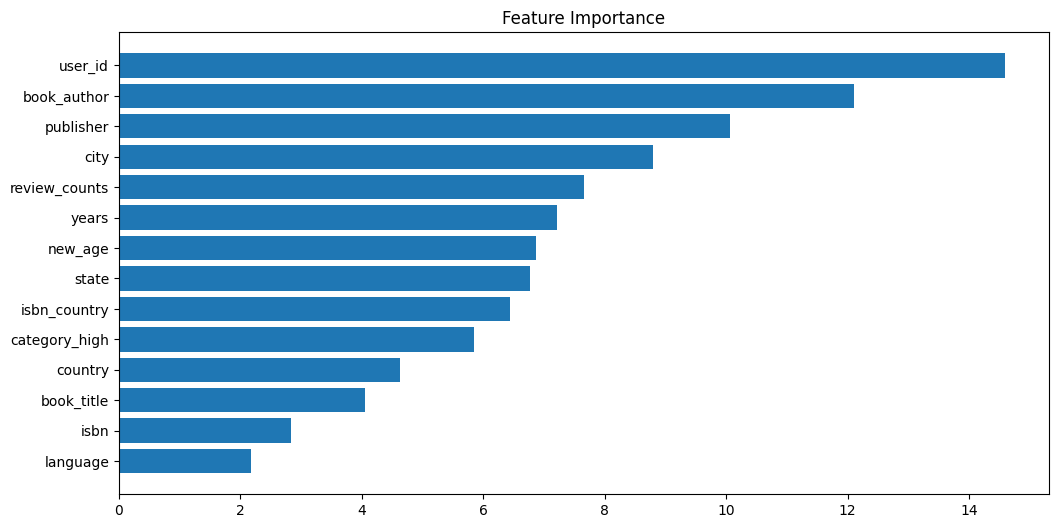

In [130]:
feature_importance = cat_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [131]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                     pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,7.207394
1,116866,0002005018,7.231461
2,152827,0060973129,7.245058
3,157969,0374157065,7.563367
4,67958,0399135782,7.753247
...,...,...,...
76694,278543,1576734218,5.997184
76695,278563,3492223710,6.096248
76696,278633,1896095186,6.354181
76697,278668,8408044079,5.355587


In [132]:
submit.to_csv('/home/code/submit/CB_HPO_Pred_punblisher_jun.csv', index = False)